**1. Import Libraries**

All libraries necessary for this recommender systems project will be imported below.

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split  

from sklearn.metrics import mean_absolute_error, mean_squared_error

**2. Data Understanding**

Load data from links, movies, ratings, and tags csvs into dataframes to get a clear understanding of the contents of these data.

In [2]:
links_df = pd.read_csv('.\data\links.csv')

print(links_df.shape)
print(links_df.duplicated().sum())
print(links_df.isna().sum())
links_df.head()

(9742, 3)
0
movieId    0
imdbId     0
tmdbId     8
dtype: int64


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


The links df contains unique identifiers used in various movie data sources. For instance:

* **movieId:** an identifier for MovieLens (*movielens.org*).

* **imdbId:** an identifier for IMDB (*imdb*).

* **tmdbId:** an identifier for The Movie Database (*themoviedb.org*).

This project will utilize the movieId identifier from MovieLens; therefore, the null values in the tmdbId column will be ignored, as they are irrelevant to the project's objectives.

In [3]:
movies_df = pd.read_csv('.\data\movies.csv')

print(movies_df.shape)
print(movies_df.duplicated().sum())
print(movies_df.isna().sum())
movies_df.head()

(9742, 3)
0
movieId    0
title      0
genres     0
dtype: int64


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df = pd.read_csv(r'C:\Users\pc\Documents\Projects\Supervised_Machine_Learning_Algorithms_for_Refined_Recommender_System_Models\data\ratings.csv')

print(ratings_df.shape)
print(ratings_df.duplicated().sum())
print(ratings_df.isna().sum())
ratings_df.head()

(100836, 4)
0
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags_df = pd.read_csv(r'C:\Users\pc\Documents\Projects\Supervised_Machine_Learning_Algorithms_for_Refined_Recommender_System_Models\data\tags.csv')

print(tags_df.shape)
print(tags_df.duplicated().sum())
print(tags_df.isna().sum())
tags_df.head()

(3683, 4)
0
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


**3. Exploratory Data Analysis (EDA)**

All the relevant DataFrames are clean; however, given the nature of **recommender system machine learning algorithms**, the provided data is too congested and may not be efficient enough to achieve a high level of accuracy. 

Therefore, the **EDA process** will be used to expand the existing categorical data, creating more usable features.

Start the EDA process by converting the timestamps in **ratings_df** and **tags_df**.

In [6]:
def process_timestamps(ratings_df):
    
    # Convert 'timestamp' column to datetime
    ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
    
    # Extract various date and time components
    ratings_df['year'] = ratings_df['timestamp'].dt.year
    ratings_df['month'] = ratings_df['timestamp'].dt.month
    ratings_df['day'] = ratings_df['timestamp'].dt.day
    ratings_df['hour'] = ratings_df['timestamp'].dt.hour
    ratings_df['minute'] = ratings_df['timestamp'].dt.minute
    ratings_df['second'] = ratings_df['timestamp'].dt.second

    # Drop the original 'timestamp' column
    ratings_df = ratings_df.drop(columns=['timestamp'])
    
    return ratings_df

ratings_df = process_timestamps(ratings_df)
ratings_df.head()

,userId,movieId,rating,year,month,day,hour,minute,second
0,1,1,4.0,2000,7,30,18,45,3
1,1,3,4.0,2000,7,30,18,20,47
2,1,6,4.0,2000,7,30,18,37,4
3,1,47,5.0,2000,7,30,19,3,35
4,1,50,5.0,2000,7,30,18,48,51


In [7]:
tags_df = process_timestamps(tags_df)
tags_df.head()

,userId,movieId,tag,year,month,day,hour,minute,second
0,2,60756,funny,2015,10,24,19,29,54
1,2,60756,Highly quotable,2015,10,24,19,29,56
2,2,60756,will ferrell,2015,10,24,19,29,52
3,2,89774,Boxing story,2015,10,24,19,33,27
4,2,89774,MMA,2015,10,24,19,33,20


Proceed by exploding the **genres** column in **movies_df** to address potential sparsity issues.

In [8]:
print('Previous total no. of genres:', movies_df.genres.nunique())

movies_df['genres'] = movies_df['genres'].str.split('|')
movies_df = movies_df.explode('genres')

print('New total no. of genres:', movies_df.genres.nunique())
print(movies_df.genres.value_counts())
movies_df.head()

Previous total no. of genres: 951
New total no. of genres: 20
genres
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64


,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


The total number of genres dropped from **951 to 20**, which is a good remedy for sparsity.

Merge **movies_df** with both **ratings_df** and **tags_df** to enrich the dataset with sufficient information.

In [9]:
# Merge ratings_df to movies_df
movie_ratings_df = pd.merge(ratings_df, movies_df, on='movieId', how='left')

print(movie_ratings_df.shape)
movie_ratings_df.head()

(274480, 11)


,userId,movieId,rating,year,month,day,hour,minute,second,title,genres
0,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Adventure
1,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Animation
2,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Children
3,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Comedy
4,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Fantasy


In [10]:
tags_movies_df = pd.merge(tags_df, movies_df, on = 'movieId', how = 'left')

print(tags_movies_df.shape)
print(tags_movies_df.tag.nunique())
tags_movies_df.head(10)

(9938, 11)
1589


,userId,movieId,tag,year,month,day,hour,minute,second,title,genres
0,2,60756,funny,2015,10,24,19,29,54,Step Brothers (2008),Comedy
1,2,60756,Highly quotable,2015,10,24,19,29,56,Step Brothers (2008),Comedy
2,2,60756,will ferrell,2015,10,24,19,29,52,Step Brothers (2008),Comedy
3,2,89774,Boxing story,2015,10,24,19,33,27,Warrior (2011),Drama
4,2,89774,MMA,2015,10,24,19,33,20,Warrior (2011),Drama
5,2,89774,Tom Hardy,2015,10,24,19,33,25,Warrior (2011),Drama
6,2,106782,drugs,2015,10,24,19,30,54,"Wolf of Wall Street, The (2013)",Comedy
7,2,106782,drugs,2015,10,24,19,30,54,"Wolf of Wall Street, The (2013)",Crime
8,2,106782,drugs,2015,10,24,19,30,54,"Wolf of Wall Street, The (2013)",Drama
9,2,106782,Leonardo DiCaprio,2015,10,24,19,30,51,"Wolf of Wall Street, The (2013)",Comedy


All the dataframes are now clean and ready for analysis and machine learning.

In [11]:
print('Total number of users:', movie_ratings_df.userId.nunique())
print('Total number of movies:', movie_ratings_df.movieId.nunique())

Total number of users: 610
Total number of movies: 9724


**4. Data Analysis**

This step is crucial for gaining a clear understanding of data distribution patterns, which will guide the selection of appropriate algorithms for the recommender system.

rating
4.0    73030
3.0    54292
3.5    36473
5.0    36452
4.5    23883
2.0    19890
2.5    14982
1.0     7156
1.5     4628
0.5     3694
Name: count, dtype: int64


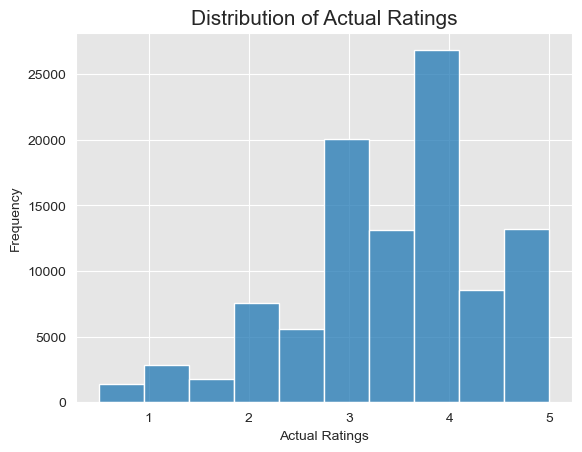

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(movie_ratings_df.rating.value_counts())

# Setting a style for the plots
sns.set_style('darkgrid', {'axes.facecolor':'0.9'})

# Plotting the distribution of ratings
sns.histplot(ratings_df['rating'], bins=10)
plt.title('Distribution of Actual Ratings', fontsize=15)
plt.xlabel('Actual Ratings')
plt.ylabel('Frequency')
plt.show()

The ratings distribution takes a skewed and modal pattern.

* The ratings range from 0.5 to 5.0 with most ratings concentrated between 3.0 and 5.0.

* There is a noticeable drop in frequency for ratings below 3.0, indicating that lower ratings are less common.

* The highest frequency occurs at 4.0, with 73,030 ratings. This suggests that users tend to give higher ratings on average.

* The second most common rating is 3.0 with 54,292 ratings, followed by 3.5 and 5.0, both of which have significant frequencies.

* The presence of both high (4.0 and 5.0) and moderate (3.0 and 3.5) ratings suggests some bimodal characteristics, where users either rate items highly or moderately, with fewer low ratings.

* The distribution has a long tail on the lower end (1.0, 0.5), indicating that while high ratings are prevalent, there are still some items that receive very low ratings, albeit much less frequently.

Adressing the sparse representation of low ratings will be pivotal in selecting the right algorithm for this recommender systems project.

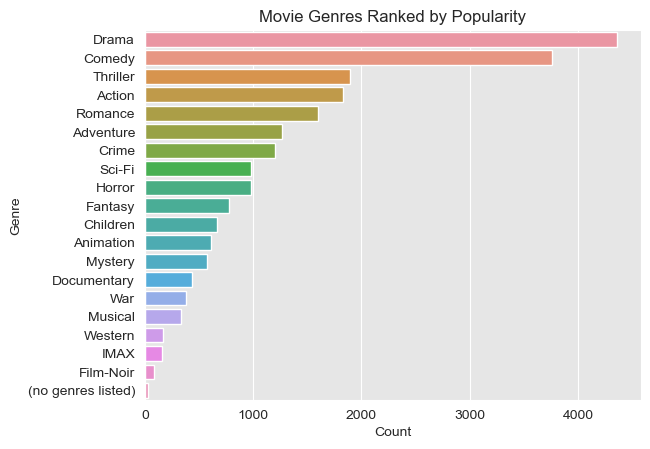

In [13]:
genres = (movies_df['genres'])

# Plot movie genres according to populariy
sns.countplot(y=genres, order=genres.value_counts().index)
plt.title('Movie Genres Ranked by Popularity')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

There is a strong preference for Drama, closely followed by Comedy. Thriller and Action also have solid popularity. While niche genres like Film-Noir and Western have a smaller audience base.

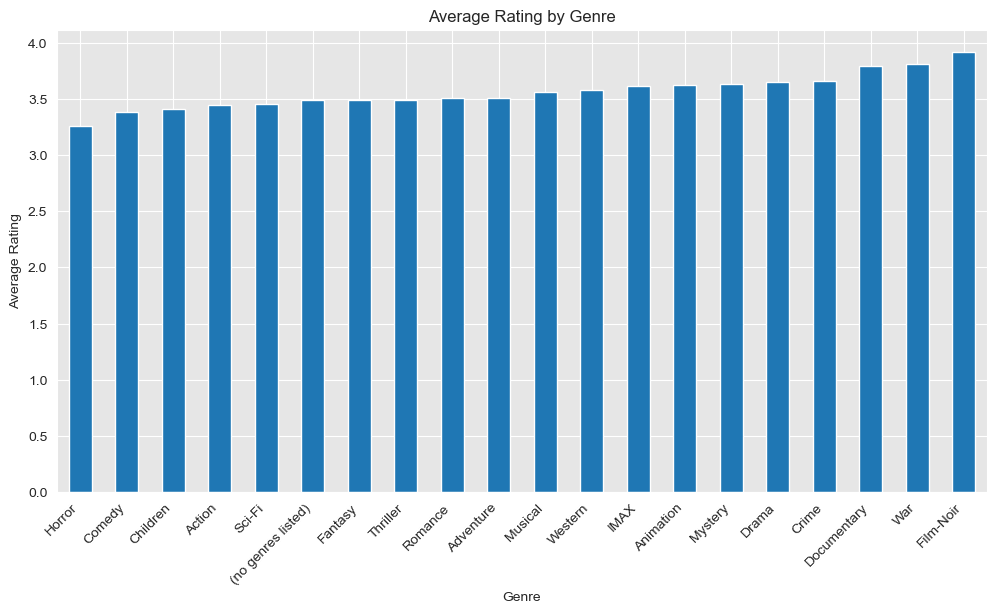

In [14]:
avg_genre_ratings = movies_df.merge(ratings_df, on='movieId').groupby('genres')['rating'].mean().sort_values()

plt.figure(figsize=(12, 6))
avg_genre_ratings.plot(kind='bar')
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

While genres indicate preference, they do not have a direct influence on ratings. Therefore, genre preference is not directly influenced by ratings, as the average rating bars for each genre in the above graph are close to each other, with Film-Noir having the highest rating. Thus, there is no bias present.

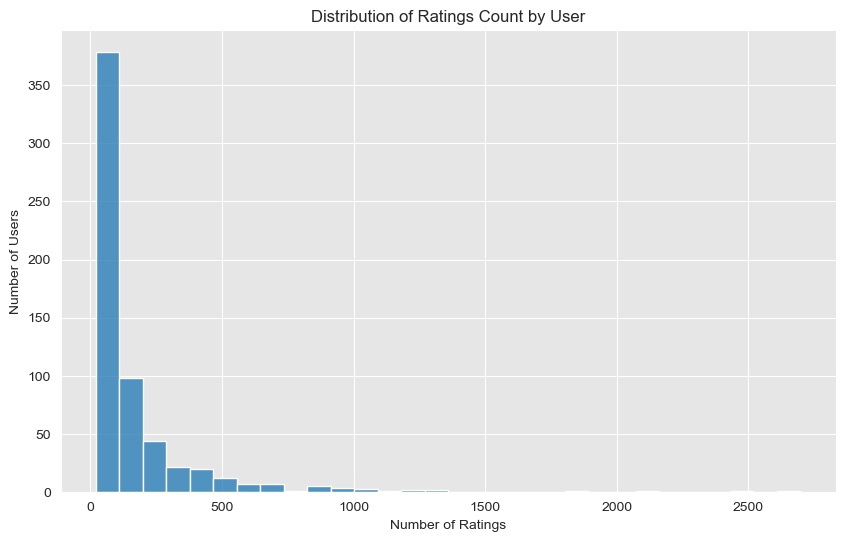

In [15]:
ratings_count_by_user = ratings_df['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_count_by_user, bins=30)
plt.title('Distribution of Ratings Count by User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

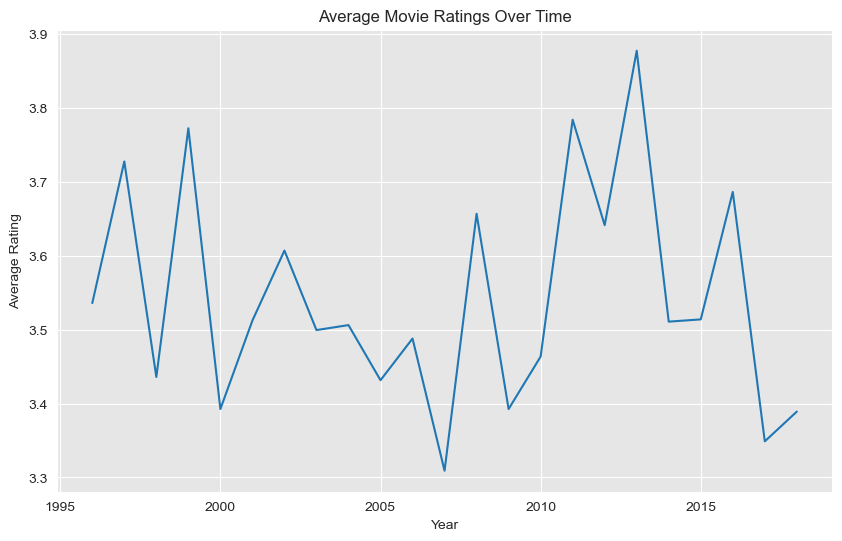

In [16]:
# Convert timestamp to datetime
yearly_ratings = ratings_df.groupby('year')['rating'].mean().reset_index()

# Line plot for average rating per year
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='rating', data=yearly_ratings)
plt.title('Average Movie Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

Average movie ratings has been declining over the years which could be influenced by several factors in the audience preferences and the recommender systems algorithms. Such factors could be; 

* bias in recommendations

* reduced diversity

* shifts in user preferences

* insufficient content quality assessment

* insufficient adaptation to trends by the existing movie recommender systems.

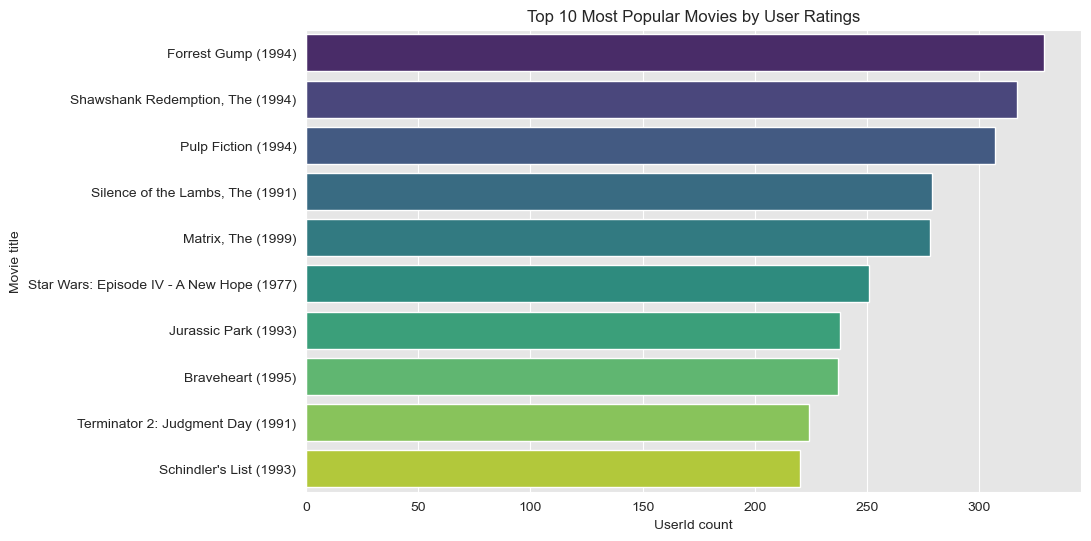

In [17]:
# Group by title and count unique users (userId)
movie_user_counts = movie_ratings_df.groupby('title')['userId'].nunique().sort_values(ascending=False)
top_10_movies = movie_user_counts.head(10).reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x= 'userId', y= 'title', data= top_10_movies, palette= 'viridis')
plt.xlabel('UserId count')
plt.ylabel('Movie title')
plt.title('Top 10 Most Popular Movies by User Ratings')

plt.show()

Now that there is a better understanding of the provided data, we can proceed to build recommender system algorithms that will address the biases and inadequacies of the data using machine learning.

**5. Recommendation Systems Algorithms.**

- KNN algorithm

*a. User-based collaborative filtering*

Begin by building a recommender system using user-based collaborative filtering with the assistance of the KNN algorithm. 

This approach focuses on users, enabling the system to recommend items based on the preferences and ratings of similar users.

In [18]:
# Create User-Item Matrix
user_movie_matrix = movie_ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
user_movie_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Perform a train-test split on the movie_ratings_df, then create a user-item matrix for both the training and testing sets.

In [19]:
# from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(movie_ratings_df, test_size= 0.2, random_state= 42)

# Train test matrices from the split data
train_matrix = trainset.pivot_table(index= 'userId', columns= 'movieId', values= 'rating').fillna(0)
test_matrix = testset.pivot_table(index= 'userId', columns= 'movieId', values= 'rating').fillna(0)

Define a pipeline for the user-item KNN model to ensure that there is no data leakage, then fit the training matrix into the pipeline.

In [20]:
# Define the pipeline steps
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors= 6)) 
])

pipeline_knn.fit(train_matrix)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 NearestNeighbors(algorithm='brute', metric='cosine',
                                  n_neighbors=6))])

Derive the top 5 neighbors for each user and their cosine similarity distances for further analysis.

In [21]:
test_matrix = test_matrix.reindex(columns=train_matrix.columns, fill_value=0)

# K-nearest neighbors for users in test_matrix
distances, indices = pipeline_knn.named_steps['knn'].kneighbors(test_matrix, n_neighbors= 6)

# Loop through each user index to print the organized output
for user_index in range(len(distances)):
    print(f"User ID {user_index + 1}:")
    
    for neighbor_index, distance in zip(indices[user_index][1:], distances[user_index][1:]):
        print(f"  Similar Users: {neighbor_index}, Similarity distance: {distance:.4f}")

    print()

User ID 1:
  Similar Users: 327, Similarity distance: 0.8679
  Similar Users: 589, Similarity distance: 0.8843
  Similar Users: 56, Similarity distance: 0.8965
  Similar Users: 312, Similarity distance: 0.8990
  Similar Users: 44, Similarity distance: 0.9043

User ID 2:
  Similar Users: 1, Similarity distance: 0.7708
  Similar Users: 246, Similarity distance: 0.8486
  Similar Users: 416, Similarity distance: 0.8567
  Similar Users: 365, Similarity distance: 0.8621
  Similar Users: 434, Similarity distance: 0.8717

User ID 3:
  Similar Users: 376, Similarity distance: 0.9284
  Similar Users: 137, Similarity distance: 0.9475
  Similar Users: 185, Similarity distance: 0.9487
  Similar Users: 15, Similarity distance: 0.9542
  Similar Users: 0, Similarity distance: 0.9618

User ID 4:
  Similar Users: 329, Similarity distance: 0.8832
  Similar Users: 596, Similarity distance: 0.8934
  Similar Users: 390, Similarity distance: 0.8991
  Similar Users: 327, Similarity distance: 0.9024
  Similar 

Plot a histogram for the similarity distances to analyse the effeciency of the user based collaborative filtering model.

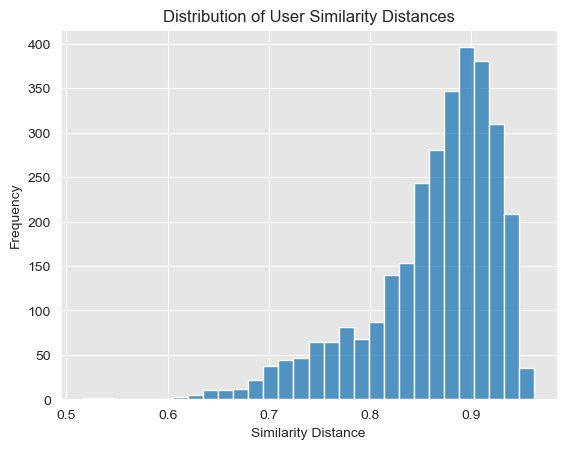

In [22]:
# Flatten the distances array excluding the first column (self-distances)
similarity_distances_flat = distances[:, 1:].flatten()

sns.histplot(similarity_distances_flat, bins=30)
plt.title('Distribution of User Similarity Distances')
plt.xlabel('Similarity Distance')
plt.ylabel('Frequency')
plt.show()

The distribution of cosine similarity distances among the users is negatively skewed, indicating that most of the distances are clustered towards the higher end of the scale, close to 1.0. This suggests that the majority of users have low similarity scores with their nearest neighbors.

There is a short tail extending towards the left, showing very few instances of high similarity.

Overall, this distribution suggests that the user-based collaborative filtering model does not effectively identify closely related users while also reflecting some variance in user similarity.

Proceed to predict all the ratings using user-based collaborative filtering algorithm.

In [23]:
# Predict rating for the user-based collaborative filtering.
def predict_ratings(user_index, train_matrix, distances, indices):
    similar_users = indices[user_index][1:]
    similar_distances = distances[user_index][1:]
    
    # Weighted ratings
    weighted_sum = np.zeros(train_matrix.shape[1])
    sum_of_weights = np.zeros(train_matrix.shape[1])
    
    for neighbor_index, distance in zip(similar_users, similar_distances):
        if distance > 0:
            weighted_sum += (train_matrix.iloc[neighbor_index] / distance)
            sum_of_weights += (1 / distance)
            
    # Predicted ratings
    predicted_ratings = weighted_sum / sum_of_weights
    return predicted_ratings


predictions = []

# Loop through each user in the test matrix
for user_index in range(len(test_matrix)):
    predicted_ratings = predict_ratings(user_index, train_matrix, distances, indices)
    predictions.append(predicted_ratings)

predictions_df = pd.DataFrame(predictions, columns=train_matrix.columns)

Evaluate the performance of the knn user-based algorithm model.

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract actual ratings from the test matrix and convert to numpy array
actual_ratings = test_matrix.values
predictions_array = predictions_df.values

# Compare only where ratings exist in the test set
mask = actual_ratings != 0  
actual_ratings = actual_ratings[mask]
predictions_array = predictions_array[mask]


mae = mean_absolute_error(actual_ratings, predictions_array)
print(f"Mean Absolute Error: {mae:.4f}")

rmse = np.sqrt(mean_squared_error(actual_ratings, predictions_array))
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Absolute Error: 2.1808
Root Mean Squared Error: 2.5332


The Mean Absolute Error of 2.1808 indicates that, on average, the predicted ratings differ from the actual ratings by about 2.18 units. Given that the rating scale spans from 0.5 to 5, this level of error is significant.

The Root Mean Squared Error of 2.5332 suggests that the model's predictions deviate from the actual ratings by an average of approximately 2.53 units. This is also a considerable error, especially since it can result in predictions that range outside the intended scale.

Both the MAE and RMSE values highlight significant inaccuracies in the predictions of the user-based collaborative filtering model. Given the scale of 0.5 to 5, these errors can lead to misinterpretations of user preferences.

Lets have a look at the predicted ratings distribution to verify the evaluation scores.

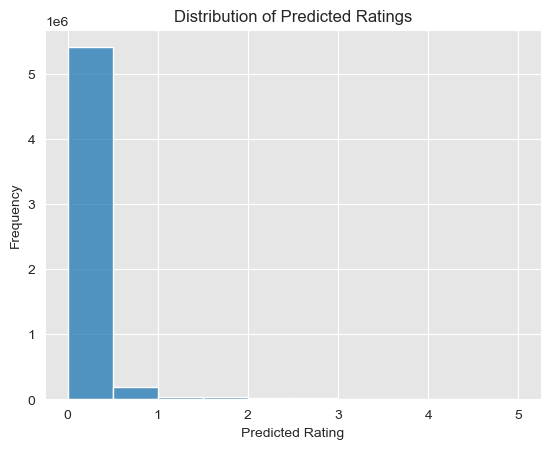

In [25]:
# Flatten the predicted ratings DataFrame to get a 1D array of all predicted ratings
predicted_ratings_flat = predictions_df.values.flatten()

sns.histplot(predicted_ratings_flat, bins=10)
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')

plt.show()

The user-based predicted ratings' histogram is negatively skewed, with the majority of the predicted ratings falling below 0.5, which is below most of the actual ratings. Therefore, the user-based collaborative filtering model is inadequate, which could be due to the sparsity of the provided data that made it difficult for the model to identify patterns accurately.

To address this issue, let's move to the item-based collaborative filtering model.

*b. Item-based collaborative filtering*

In [26]:
# Create Item-User Matrix
movie_user_matrix = movie_ratings_df.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Perform a train-test split on the movie_ratings_df, then create a item-user matrix for both the training and testing sets.

In [27]:
trainset, testset = train_test_split(movie_ratings_df, test_size= 0.2, random_state= 42)

# Train test matrices from the split data
train_matrix = trainset.pivot_table(index= 'movieId', columns= 'userId', values= 'rating').fillna(0)
test_matrix = testset.pivot_table(index= 'movieId', columns= 'userId', values= 'rating').fillna(0)

Define a pipeline for the item-user KNN model to prevent potential data leakages, then fit the training matrix into the pipeline.

In [28]:
# Define the pipeline steps
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors= 6)) 
])

pipeline_knn.fit(train_matrix)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 NearestNeighbors(algorithm='brute', metric='cosine',
                                  n_neighbors=6))])

In [29]:
test_matrix = test_matrix.reindex(columns=train_matrix.columns, fill_value=0)

# K-nearest neighbors for users in test_matrix
distances, indices = pipeline_knn.named_steps['knn'].kneighbors(test_matrix, n_neighbors= 6)

# Loop through each user index to print the organized output
for movie_index in range(len(distances)):
    print(f"Movie ID {movie_index + 1}:")
    
    for neighbor_index, distance in zip(indices[movie_index][1:], distances[movie_index][1:]):
        print(f"  Similar Movies: {neighbor_index}, Similarity distance: {distance:.4f}")

    print()

Movie ID 1:
  Similar Movies: 542, Similarity distance: 0.6124
  Similar Movies: 610, Similarity distance: 0.6162
  Similar Movies: 2319, Similarity distance: 0.6559
  Similar Movies: 959, Similarity distance: 0.6664
  Similar Movies: 321, Similarity distance: 0.6683

Movie ID 2:
  Similar Movies: 321, Similarity distance: 0.6601
  Similar Movies: 501, Similarity distance: 0.7151
  Similar Movies: 480, Similarity distance: 0.7155
  Similar Movies: 503, Similarity distance: 0.7201
  Similar Movies: 509, Similarity distance: 0.7335

Movie ID 3:
  Similar Movies: 7, Similarity distance: 0.6174
  Similar Movies: 636, Similarity distance: 0.6811
  Similar Movies: 429, Similarity distance: 0.6984
  Similar Movies: 71, Similarity distance: 0.7104
  Similar Movies: 361, Similarity distance: 0.7211

Movie ID 4:
  Similar Movies: 311, Similarity distance: 0.4635
  Similar Movies: 261, Similarity distance: 0.5140
  Similar Movies: 413, Similarity distance: 0.5288
  Similar Movies: 99, Similarity 

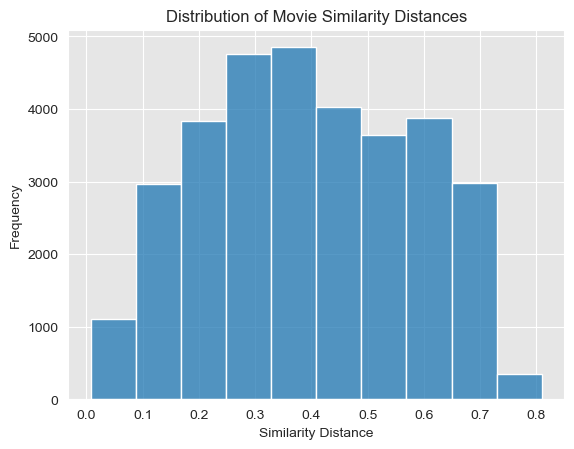

In [30]:
# Flatten the distances array excluding the first column (self-distances)
similarity_distances_flat = distances[:, 1:].flatten()

sns.histplot(similarity_distances_flat, bins=10)
plt.title('Distribution of Movie Similarity Distances')
plt.xlabel('Similarity Distance')
plt.ylabel('Frequency')
plt.show()

Overall, the item-based collaborative filtering (CF) model's distance distribution highlights a diverse range of movie similarities, with a notable concentration of cosine distances between 0.2 and 0.5, indicating that these movies are moderately related. Additionally, there are instances of very high similarity, reflected by distances below 0.2.

This could be a better substitution of the user-based model. Lets evaluate the model performace to evaluate its accuracy. First start with predicting ratings.

In [31]:
# Predict ratings
def predict_ratings(movie_index, train_matrix, distances, indices):
    similar_movies = indices[movie_index][1:]
    similar_distances = distances[movie_index][1:]
    
    # Weighted ratings
    weighted_sum = np.zeros(train_matrix.shape[1])
    sum_of_weights = np.zeros(train_matrix.shape[1])
    
    for neighbor_index, distance in zip(similar_movies, similar_distances):
        if distance > 0:
            weighted_sum += (train_matrix.iloc[neighbor_index] / distance)
            sum_of_weights += (1 / distance)
            
    # Predicted ratings
    predicted_ratings = weighted_sum / sum_of_weights
    return predicted_ratings


predictions = []

# Loop through each user in the test matrix
for movie_index in range(len(test_matrix)):
    predicted_ratings = predict_ratings(movie_index, train_matrix, distances, indices)
    predictions.append(predicted_ratings)

predictions_df = pd.DataFrame(predictions, columns=train_matrix.columns)

In [ ]:
# Average predicted ratings for each movie
average_ratings = predictions_df.mean(axis=0)

# Create a DataFrame for better organization
average_ratings_df = pd.DataFrame({
    'movieId': average_ratings.index,
    'Average Predicted Rating': average_ratings.values
})

average_ratings_df = average_ratings_df.sort_values(by='Average Predicted Rating', ascending= False)
average_ratings_list = average_ratings_df.values.tolist()


print("Average Predicted Ratings for Movies:")
for movie_id, avg_rating in average_ratings_list:
    print(f"Movie ID {movie_id}: Average Rating {avg_rating:.2f}")


Average Predicted Ratings for Movies:
Movie ID 414.0: Average Rating 0.94
Movie ID 474.0: Average Rating 0.69
Movie ID 599.0: Average Rating 0.66
Movie ID 448.0: Average Rating 0.56
Movie ID 610.0: Average Rating 0.53
Movie ID 380.0: Average Rating 0.51
Movie ID 274.0: Average Rating 0.45
Movie ID 249.0: Average Rating 0.41
Movie ID 68.0: Average Rating 0.39
Movie ID 606.0: Average Rating 0.35
Movie ID 387.0: Average Rating 0.33
Movie ID 182.0: Average Rating 0.31
Movie ID 288.0: Average Rating 0.31
Movie ID 318.0: Average Rating 0.30
Movie ID 232.0: Average Rating 0.30
Movie ID 603.0: Average Rating 0.29
Movie ID 177.0: Average Rating 0.27
Movie ID 480.0: Average Rating 0.27
Movie ID 305.0: Average Rating 0.26
Movie ID 307.0: Average Rating 0.25
Movie ID 483.0: Average Rating 0.25
Movie ID 608.0: Average Rating 0.25
Movie ID 105.0: Average Rating 0.25
Movie ID 590.0: Average Rating 0.23
Movie ID 534.0: Average Rating 0.23
Movie ID 298.0: Average Rating 0.21
Movie ID 477.0: Average Rat

Model evaluation

In [33]:
# Create a new DataFrame with actual and predicted ratings
ratings_comparison_df = testset.merge(average_ratings_df[['movieId', 'Average Predicted Rating']], on='movieId', how='left')

# Drop rows with missing predicted ratings
ratings_comparison_df = ratings_comparison_df.dropna(subset=['Average Predicted Rating'])

# Calculate MAE and RMSE
mae = mean_absolute_error(ratings_comparison_df['rating'], ratings_comparison_df['Average Predicted Rating'])
rmse = np.sqrt(mean_squared_error(ratings_comparison_df['rating'], ratings_comparison_df['Average Predicted Rating']))

print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')


MAE: 3.4731, RMSE: 3.6226


An MAE of 3.4731 indicates that, on average, the predicted ratings deviate from the actual ratings by about 3.47 units on the rating scale. This is a relatively significant error, especially considering that the rating scale likely ranges from 0.5 to 5. 

An RMSE of 3.6226 reflects the square root of the average squared differences between predicted and actual ratings. Like the MAE, an RMSE of 3.62 indicates a substantial error in predictions, further emphasizing that the model struggles to accurately predict item ratings.

Possible causes of these high error scores could be sparcity of data, inadequate feature representation, bias in data or lack of diversity in user ratings.

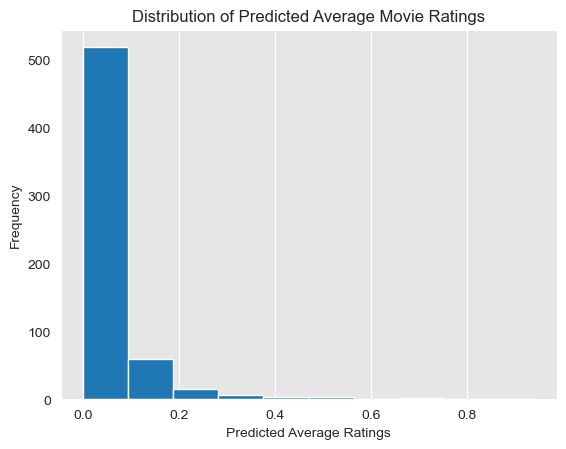

In [34]:
plt.hist(average_ratings_df['Average Predicted Rating'], bins=10)
plt.title('Distribution of Predicted Average Movie Ratings')
plt.xlabel('Predicted Average Ratings')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

The item-based predicted ratings' histogram is also positively skewed, with the majority of the predicted ratings also falling below 0.5, which is below most of the actual ratings. Therefore, the item-based collaborative filtering model is equally inadequate.

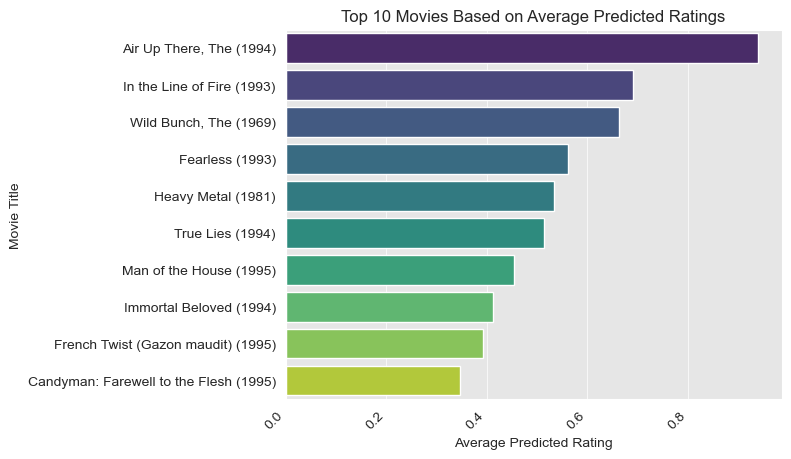

In [35]:
# Merge the two DataFrames to get titles
top_movies_df = average_ratings_df.merge(movies_df[['movieId', 'title']], on='movieId')
top_movies_df = top_movies_df.drop_duplicates(subset=['movieId'])

top_10_movies = top_movies_df.sort_values(by='Average Predicted Rating', ascending=False).head(10)


sns.barplot( x= top_10_movies['Average Predicted Rating'], y= top_10_movies['title'], palette= 'viridis')
plt.xlabel('Average Predicted Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies Based on Average Predicted Ratings')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', alpha=0.7)
plt.show()

Given the nature of the available data, both memory-based collaborative filtering models have significantly failed to address the existing biases present in the provided dataset. For this reason, transitioning to a model-based collaborative filtering algorithm would be more effective.

- Model-based algorithm

From the previous analyses, the provided data did not respond well to memory-based collaborative filtering because the patterns in the data were insufficient for accurately predicting ratings. A model-based approach will instead utilize Singular Value Decomposition (SVD), a matrix factorization technique that uncovers latent factors to improve rating predictions.

For optimal results, GridSearchCV will be applied to the SVD model to systematically search for the best combination of hyperparameters using cross-validation. Additionally, the dataset (movie_ratings_df) will be split into training and testing sets, and the training set will be fit into the SVD algorithm using the Surprise library.

In [36]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

# Load data into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(movie_ratings_df[['userId', 'movieId', 'rating']], reader)

# Define parameter grid for grid search
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
grid_search.fit(data)

best_params = grid_search.best_params['rmse']
print("Best parameters:", best_params)

# Train-test split
algo = SVD(**best_params)
trainset, testset = train_test_split(data, test_size=0.25, random_state= 42)

# algo = SVD()
algo.fit(trainset)

Best parameters: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02}


Perform model evaluation.

In [37]:
predictions = algo.test(testset)

# Model evaluation
accuracy.rmse(predictions)

RMSE: 0.3905


0.390524401913551

An RMSE of 0.3905 is relatively low, implying that the SVD model is doing a decent job at capturing user preferences and movie characteristics.

On average, the predicted ratings deviate from the actual ratings by approximately 0.39 points on the rating scale, which ranges from 0.5 to 5. This level of deviation suggests that while the model's predictions are generally close to the actual ratings, there is still a noticeable margin of error.

Plot ahistogram to compare the distribution of the actual ratings and the predicted ratings.

In [38]:
predictions_df = pd.DataFrame(predictions, columns= ['user_id', 'item_id', 'true_rating', 'estimated_rating', 'details'])
predictions_df.head(10)

,user_id,item_id,true_rating,estimated_rating,details
0,480,30707,4.0,3.474101,{'was_impossible': False}
1,57,3624,4.0,3.799321,{'was_impossible': False}
2,217,2870,4.0,2.638566,{'was_impossible': False}
3,599,922,2.5,3.144386,{'was_impossible': False}
4,23,3681,3.5,3.553458,{'was_impossible': False}
5,416,608,4.5,4.459447,{'was_impossible': False}
6,225,2248,4.0,4.012176,{'was_impossible': False}
7,232,4638,3.5,3.396664,{'was_impossible': False}
8,91,6807,4.0,3.664226,{'was_impossible': False}
9,101,2492,1.0,1.431100,{'was_impossible': False}


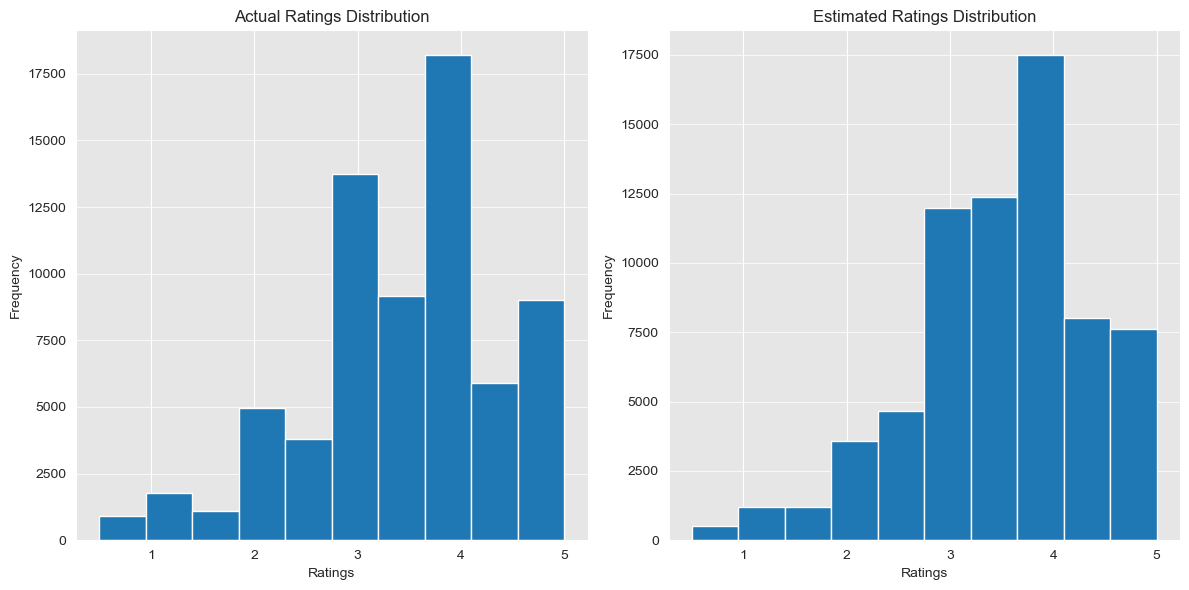

In [39]:
ratings_df = predictions_df[['true_rating', 'estimated_rating']].fillna(0)

# Set the figure size
plt.figure(figsize=(12, 6))

# Create subplots for true ratings and estimated ratings
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Histogram for true ratings
ax1.hist(ratings_df['true_rating'], bins=10)
ax1.set_title('Actual Ratings Distribution')
ax1.set_xlabel('Ratings')
ax1.set_ylabel('Frequency')
ax1.grid(axis='y', alpha=0.75)

# Histogram for estimated ratings
ax2.hist(ratings_df['estimated_rating'], bins=10)
ax2.set_title('Estimated Ratings Distribution')
ax2.set_xlabel('Ratings')
ax2.set_ylabel('Frequency')
ax2.grid(axis='y', alpha=0.75)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


There isn't much significance in the difference between the actual and predicted ratings distributions. Both distributions are negatively skewed, with the actual ratings showing a multimodal distribution pattern, while the predicted ratings exhibit a unimodal distribution pattern. Both distributions peak at a rating of 4.

This suggests that the model-based collaborative filtering using SVD is reasonably effective, as it captures a central tendency similar to that of the actual ratings.

Predict the ratings on the test set for further analysis.

In [40]:
user_ids = movie_ratings_df['userId'].unique()
movie_ids = movie_ratings_df['movieId'].unique()

# Number of reccomendations to make
N = 5
recommendations = {}

# Loop over each user
for user_id in user_ids:
    rated_movie_ids = movie_ratings_df[movie_ratings_df['userId'] == user_id]['movieId'].unique()

    unrated_movie_ids = [m_id for m_id in movie_ids if m_id not in rated_movie_ids]

    # Predict ratings for the unrated movies
    predictions = [algo.predict(user_id, m_id) for m_id in unrated_movie_ids]

    # Sort predictions by estimated rating (highest first)
    predictions.sort(key=lambda x: x.est, reverse=True)

    top_n_recommendations = predictions[:N]

    # Store the recommendations for each user
    recommendations[user_id] = [(pred.iid, pred.est) for pred in top_n_recommendations]

In [41]:
# Display top 5 recommendations for all users
for user_id, recs in recommendations.items():
    print(f'\nTop {N} recommendations for User {user_id}:')
    for movie_id, predicted_rating in recs:
        print(f'Movie ID: {movie_id}, Predicted Rating: {predicted_rating:.2f}')


Top 5 recommendations for User 1:
Movie ID: 1704, Predicted Rating: 5.00
Movie ID: 77455, Predicted Rating: 5.00
Movie ID: 720, Predicted Rating: 5.00
Movie ID: 1272, Predicted Rating: 5.00
Movie ID: 2288, Predicted Rating: 5.00

Top 5 recommendations for User 2:
Movie ID: 905, Predicted Rating: 4.58
Movie ID: 27156, Predicted Rating: 4.57
Movie ID: 541, Predicted Rating: 4.52
Movie ID: 3429, Predicted Rating: 4.50
Movie ID: 3468, Predicted Rating: 4.49

Top 5 recommendations for User 3:
Movie ID: 55820, Predicted Rating: 4.50
Movie ID: 2289, Predicted Rating: 4.16
Movie ID: 1245, Predicted Rating: 4.14
Movie ID: 599, Predicted Rating: 4.13
Movie ID: 1080, Predicted Rating: 4.08

Top 5 recommendations for User 4:
Movie ID: 17, Predicted Rating: 5.00
Movie ID: 1276, Predicted Rating: 4.99
Movie ID: 923, Predicted Rating: 4.75
Movie ID: 48774, Predicted Rating: 4.74
Movie ID: 671, Predicted Rating: 4.72

Top 5 recommendations for User 5:
Movie ID: 1219, Predicted Rating: 5.00
Movie ID: 

In [42]:
predictions_df = pd.DataFrame(predictions, columns= ['user_id', 'item_id', 'true_rating', 'estimated_rating', 'details'])
predictions_df.head()

,user_id,item_id,true_rating,estimated_rating,details
0,610,1217,None,4.949777,{'was_impossible': False}
1,610,1079,None,4.901992,{'was_impossible': False}
2,610,1275,None,4.788422,{'was_impossible': False}
3,610,1266,None,4.728462,{'was_impossible': False}
4,610,3030,None,4.724672,{'was_impossible': False}


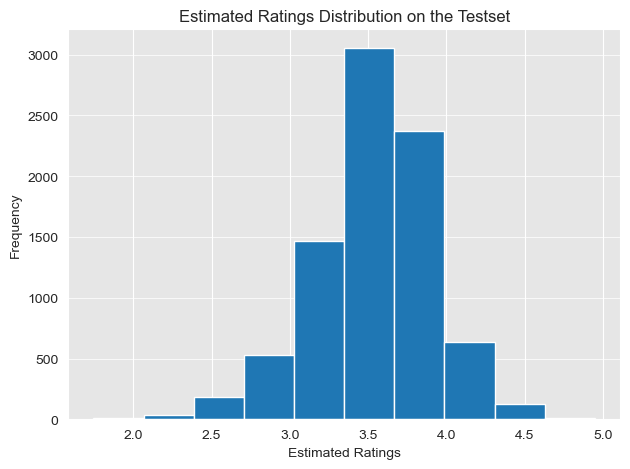

In [43]:
# Create a histogram for the estimated ratings
plt.hist(predictions_df['estimated_rating'], bins=10)

# Set titles and labels
plt.title('Estimated Ratings Distribution on the Testset')
plt.xlabel('Estimated Ratings')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.tight_layout()
plt.show()

The estimated ratings on the test set exhibit a skewed distribution, with ratings peaking within the range of 3.5 to 4.0. There isn't much deviation from the average actual ratings, which peaked at 4.

This discrepancy suggests that the model tends to underestimate the ratings by a relatively small margin, as evidenced by the lower peak in the predicted distribution compared to the actual distribution. Although the model captures the general trend of the ratings, this offset indicates room for improvement in accuracy.

Based on the results of the model-based collaborative filtering with SVD, matrix factorization using SVD performs better compared to the memory-based collaborative filtering model.

- Content based algorithm

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Using TF-IDF to compute similarity based on movie genres
movie_ratings_df['genres'] = movie_ratings_df['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Vectorize genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

# Compute similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on similarity score
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies_df[movies_df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

# Get recommendations for a specific movie
recommendations = get_recommendations('Toy Story (1995)')
print(recommendations)

1                                        Jumanji (1995)
7                                   Tom and Huck (1995)
9                                      GoldenEye (1995)
12                                         Balto (1995)
14                              Cutthroat Island (1995)
28    City of Lost Children, The (Cité des enfants p...
40                                 Mortal Kombat (1995)
48                                      Lamerica (1994)
53                   Indian in the Cupboard, The (1995)
77                                  White Squall (1996)
Name: title, dtype: object
